# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\amite\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\amite\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [5]:
df_transactions.shape

(324, 3)

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
df_customers_offers = df_transactions.merge(df_offers, on="offer_id", how='left', suffixes=["",""])

df_customers_offers.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False


In [7]:
df_customers_offers.shape

(324, 9)

In [8]:
#your turn

df_cust_offer_map = df_customers_offers.pivot_table(values='n', index = 'customer_name', columns='offer_id')
df_cust_offer_map.columns = ['offer_'+str(x) for x in df_cust_offer_map.columns]
df_cust_offer_map = df_cust_offer_map.reset_index()
df_cust_offer_map = df_cust_offer_map.fillna(0)


df_cust_offer_map.head()


,customer_name,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
df_cust_offer_map.shape

(100, 33)

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

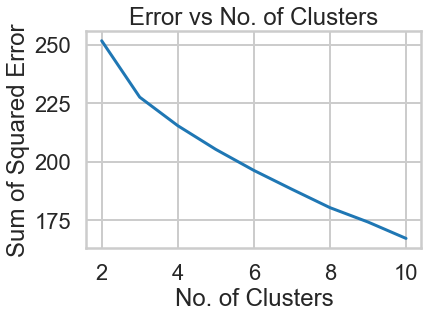

In [10]:
# your turn

from sklearn.cluster import KMeans
import numpy as np

x_cols = df_cust_offer_map.drop('customer_name', axis=1).to_numpy()

ss_error = []

K_vals = list(range(2,11))

for K in K_vals:
    model = KMeans(n_clusters = K, random_state=123)
    labels = model.fit_predict(x_cols)
    centroids = model.cluster_centers_
    ss_error.append(np.sum((x_cols - centroids[labels])**2))


plt.plot(K_vals, ss_error)
plt.xlabel('No. of Clusters')
plt.ylabel('Sum of Squared Error')
plt.title('Error vs No. of Clusters')
plt.show()


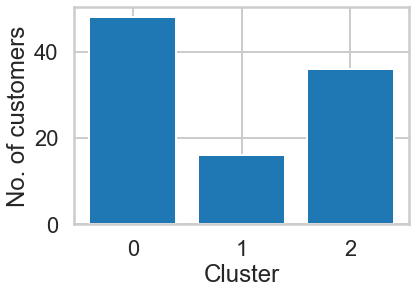

In [11]:
# As we can see in above graph, there is a 'bend' at k=3. The error declines at a slower rate after that.
# The best model is with k=3. So let's plot the no. of points in each cluster for k=3

model = KMeans(n_clusters = 3, random_state= 123)
labels = model.fit_predict(x_cols)
cluster, count = np.unique(labels, return_counts=True)

plt.bar(cluster, count)
plt.xlabel('Cluster')
plt.ylabel('No. of customers')
plt.show()



The 'Knee/Elbow' plot of squared error vs cluster for this clustering problem doesn't have a very pronounced elbow at k=3. The value of k=3 was chosen keeping in mind that the sample size was only 100 and it would be better to choose a lower value of k, to avoid overfitting and having very small cluster sizes.
        

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For No_of_clusters = 2 The average silhouette_score is : 0.08206113079944462
For No_of_clusters = 3 The average silhouette_score is : 0.12101628521627421
For No_of_clusters = 4 The average silhouette_score is : 0.12416494377606797
For No_of_clusters = 5 The average silhouette_score is : 0.11593800645322037
For No_of_clusters = 6 The average silhouette_score is : 0.1319407030176781
For No_of_clusters = 7 The average silhouette_score is : 0.09894629408384592
For No_of_clusters = 8 The average silhouette_score is : 0.12990584815609205
For No_of_clusters = 9 The average silhouette_score is : 0.11496043578541626
For No_of_clusters = 10 The average silhouette_score is : 0.13507870304456204


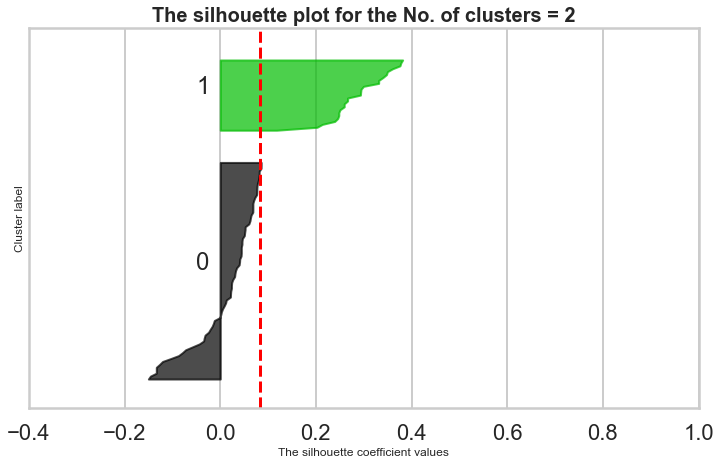

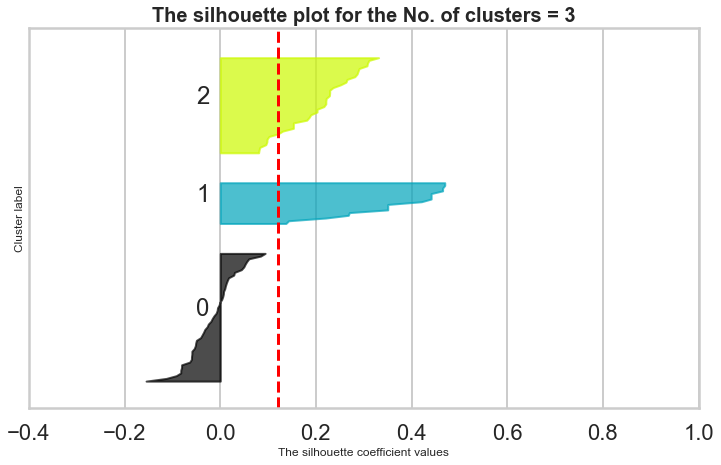

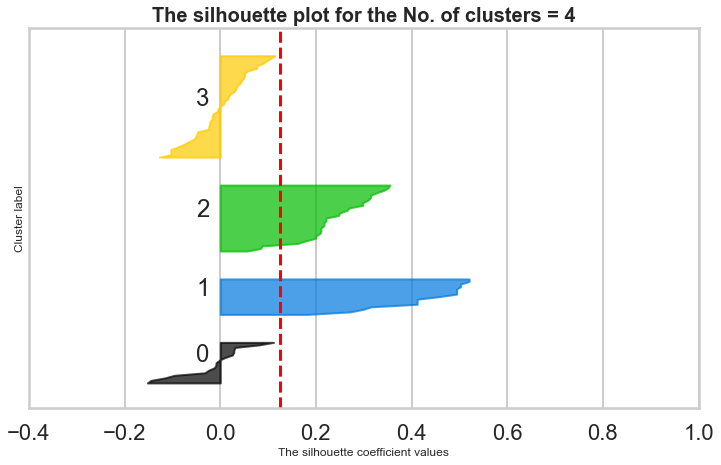

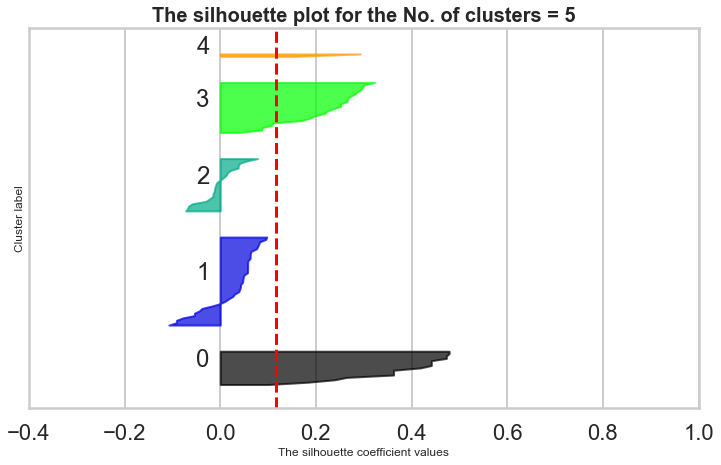

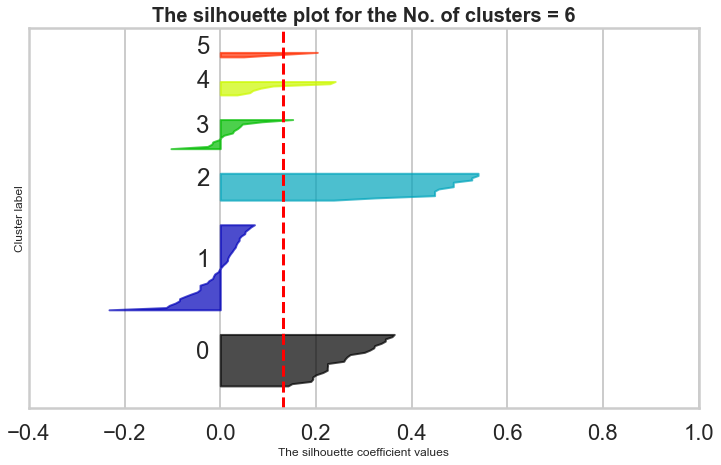

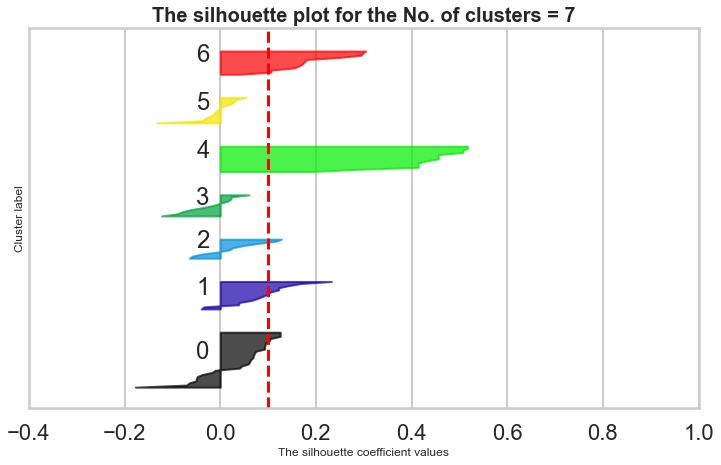

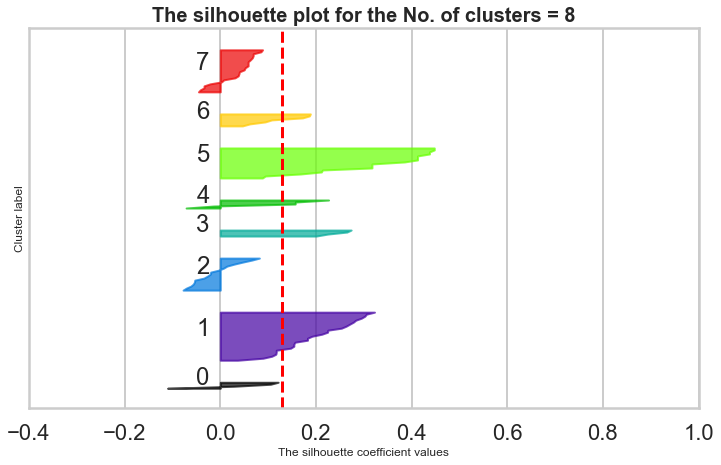

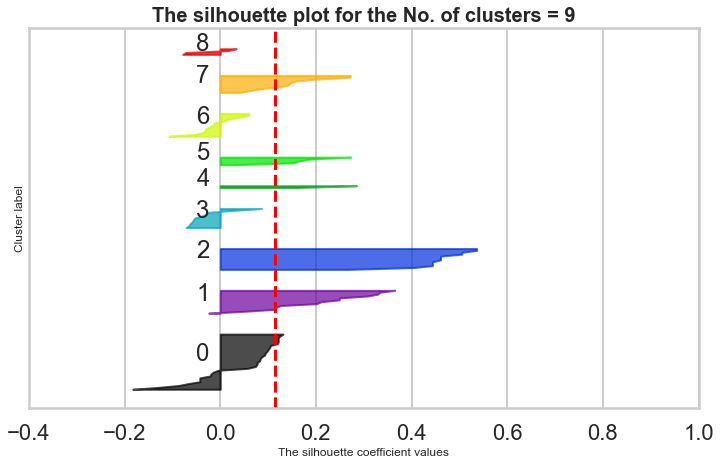

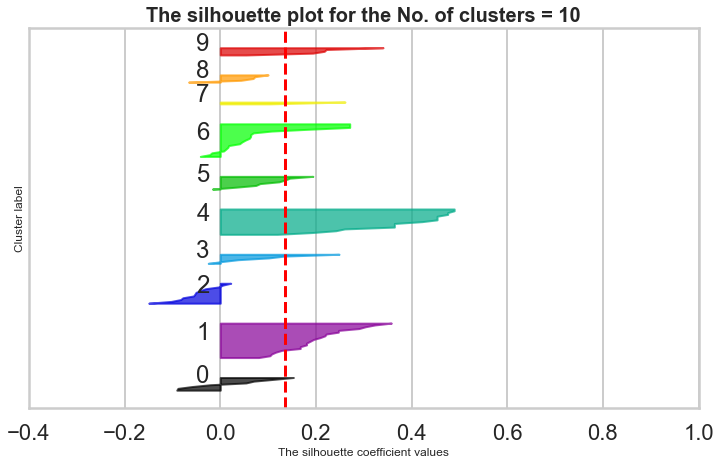

In [94]:
# Your turn.

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

avg_silhouette_score = []

for k in range(2,11):
    model = KMeans(n_clusters=k, random_state = 123)
    labels = model.fit_predict(x_cols)
    
    avg_silhouette_score.append(silhouette_score(x_cols, labels))
    print("For No_of_clusters =",k,"The average silhouette_score is :",avg_silhouette_score[-1])
    
    fig, ax = plt.subplots(figsize = (12,7))
    
    ax.set_xlim([-0.4,1])
    ax.set_ylim([0, len(labels) + (k+1)*10])
    
    sample_silhouette_score = silhouette_samples(x_cols, labels)
    y_lower = 10
    
    for i in range(k):
        
        ith_cluster_silhouette_values = sample_silhouette_score[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        
        y_lower = y_upper + 10  

    ax.set_title("The silhouette plot for the No. of clusters = %d" %k, fontsize=20, fontweight="bold")
    ax.set_xlabel("The silhouette coefficient values", fontsize=12)
    ax.set_ylabel("Cluster label", fontsize=12)

    ax.axvline(x=avg_silhouette_score[-1] , color="red", linestyle="--")

    ax.set_yticks([])  
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()
    


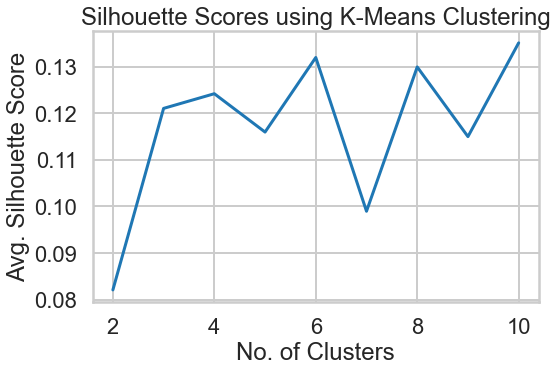

In [95]:
# plotting the average silhouette score

k =list(range(2,11))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(k, avg_silhouette_score)
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('Avg. Silhouette Score')
ax.set_title('Silhouette Scores using K-Means Clustering')
plt.show()


The overall avg. silhouette score has a max. value of **0.135** for n=10 clusters. This is still lower than the 0.25 threshold for reasonable clusters to be found. Within the available scores, the optimal no. of clusters still seems to be 3. The overall avg. silhouette score is 0.12 for this option, slightly below the best score for n=10 clusters. 

In option n=3 clusters, two of the clusters (1 & 2) have fairly decent silhouette scores for data points, mostly above 0.2 and some with scores above 0.4 as well. It is the 3rd cluster (0) that seems to be weak.

If we look at score in n=10 clusters, it again shows two strong clusters (1, 4). The balance 8 clusters are quite weak. 
So overall, n=3 still appears to be the better of the two options.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

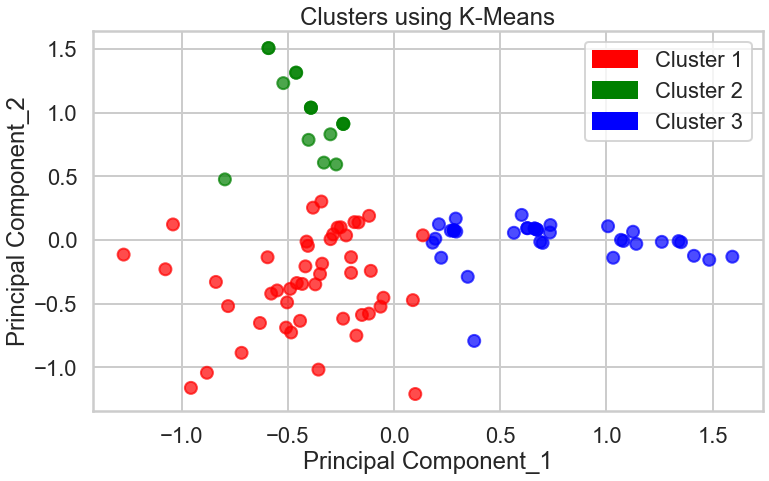

In [91]:
#your turn

from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

kmeans = KMeans(n_clusters=3, random_state = 123)
labels = kmeans.fit_predict(x_cols)
    
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))
colors = {0: 'red', 1: 'green', 2: 'blue'}


scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

red_patch = mpatches.Patch(color='red', label = 'Cluster 1')
green_patch = mpatches.Patch(color='green', label = 'Cluster 2')
blue_patch = mpatches.Patch(color='blue', label = 'Cluster 3')

ax.legend(handles=[red_patch, green_patch, blue_patch])
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title('Clusters using K-Means')
plt.show()


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [20]:
# From the raw data on offers and transactions, let's check how clusters are different based on
# a) Wine variety
# b) Wine Origin
# c) Avg. no. of offers bought

cust_variety = df_customers_offers.pivot_table(values='n', index = 'customer_name', columns=['varietal'], \
                                                 aggfunc = np.sum, fill_value=0)

cust_origin = df_customers_offers.pivot_table(values='n', index = 'customer_name', columns=['origin'], \
                                                 aggfunc = np.sum, fill_value=0)

no_of_offers = df_cust_offer_map.iloc[:, 1:].sum(axis=1)

cust_features = cust_variety.merge(cust_origin, on='customer_name')
cust_features = df_transformed.merge(cust_features, on='customer_name', suffixes=["",""])
cust_features['Offer#'] = no_of_offers

cust_features = cust_features.drop(['customer_name', 'x','y'], axis=1)

cust_features.head()



,cluster,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa,Offer#
0,2,0,0,0,1,1,0,1,0,0,0,0,0,2,0,0,0,1,0,3.0
1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2.0
2,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,1,0,0,0,2.0
3,2,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,2.0
4,0,0,2,0,0,0,0,0,0,2,1,1,0,1,1,0,0,0,0,4.0


In [21]:
# Now that we have each customer mapped to varities and orgin, let's aggregate by cluster and calculate avg. frequencies 
# in a cluster for variety, origin and no. of offers


cluster_zero = pd.DataFrame(cust_features[cust_features['cluster'] == 0].sum(axis=0) / \
                            cust_features[cust_features['cluster'] == 0].shape[0]).reset_index()

cluster_zero.columns = ['feature', 'Cluster_0']

cluster_one = pd.DataFrame(cust_features[cust_features['cluster'] == 1].sum(axis=0) / \
                            cust_features[cust_features['cluster'] == 1].shape[0]).reset_index()

cluster_one.columns = ['feature', 'Cluster_1']

cluster_two = pd.DataFrame(cust_features[cust_features['cluster'] == 2].sum(axis=0) / \
                            cust_features[cust_features['cluster'] == 2].shape[0]).reset_index()

cluster_two.columns = ['feature', 'Cluster_2']

cluster_features = cluster_zero.merge(cluster_one, on='feature').merge(cluster_two, on='feature')



In [22]:
cluster_features

,feature,Cluster_0,Cluster_1,Cluster_2
0,cluster,0.000000,1.0000,2.000000
1,Cabernet Sauvignon,0.645833,0.0000,0.027778
2,Champagne,1.541667,0.0625,0.166667
3,Chardonnay,0.291667,0.0625,0.000000
4,Espumante,0.166667,0.0000,0.888889
5,Malbec,0.291667,0.0625,0.472222
6,Merlot,0.270833,0.0625,0.166667
7,Pinot Grigio,0.020833,0.0000,0.444444
8,Pinot Noir,0.145833,2.3125,0.000000
9,Prosecco,0.437500,0.1250,0.555556


C:\Users\amite\AppData\Local\Temp/ipykernel_14324/2551886022.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[cluster].set_xticklabels(cluster_features.iloc[1:10,0],rotation=90, fontsize=14)


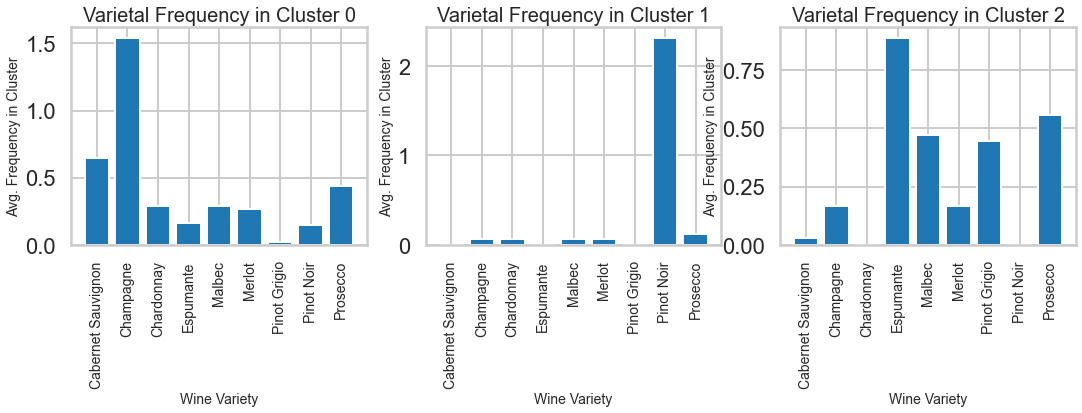

In [23]:
# Let's plot these by cluster

fig, ax = plt.subplots(1,3, figsize = (18,4))

for cluster in range(3):
    ax[cluster].bar(cluster_features.iloc[1:10,0], cluster_features.iloc[1:10,cluster+1])
    ax[cluster].set_xticklabels(cluster_features.iloc[1:10,0],rotation=90, fontsize=14)
    ax[cluster].set_xlabel('Wine Variety', fontsize=14)
    ax[cluster].set_ylabel('Avg. Frequency in Cluster', fontsize=14)
    ax[cluster].set_title('Varietal Frequency in Cluster %d'%cluster, fontsize=20)

plt.show()

C:\Users\amite\AppData\Local\Temp/ipykernel_14324/283014171.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[cluster].set_xticklabels(cluster_features.iloc[10:19,0],rotation=90, fontsize=14)


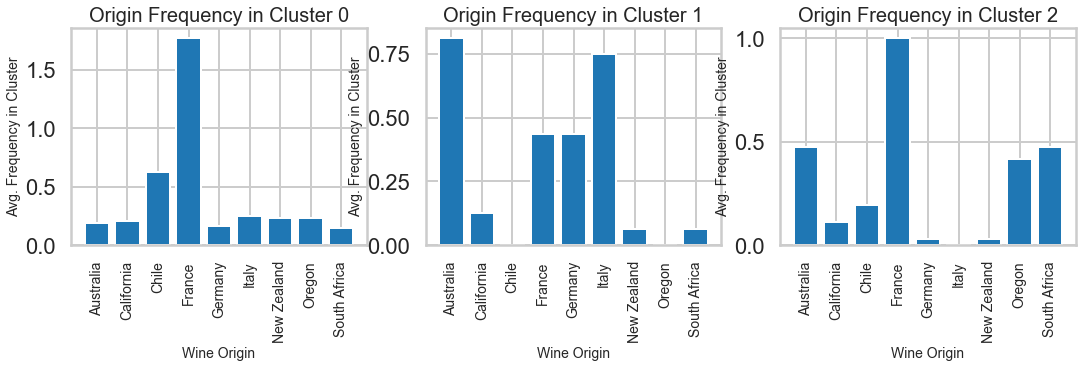

In [24]:

fig, ax = plt.subplots(1,3, figsize = (18,4))

for cluster in range(3):
    ax[cluster].bar(cluster_features.iloc[10:19,0], cluster_features.iloc[10:19,cluster+1])
    ax[cluster].set_xticklabels(cluster_features.iloc[10:19,0],rotation=90, fontsize=14)
    ax[cluster].set_xlabel('Wine Origin', fontsize=14)
    ax[cluster].set_ylabel('Avg. Frequency in Cluster', fontsize=14)
    ax[cluster].set_title('Origin Frequency in Cluster %d'%cluster, fontsize=20)

plt.show()


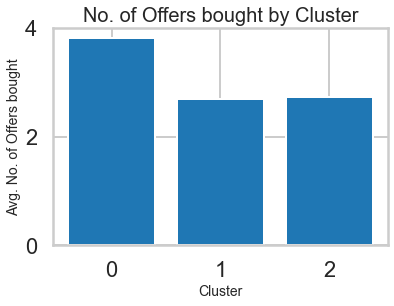

In [25]:
#fig, ax = plt.subplots(1,3, figsize = (6,4))

plt.bar(range(3), cluster_features.iloc[19,1:])
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Avg. No. of Offers bought', fontsize=14)
plt.title('No. of Offers bought by Cluster', fontsize=20)

plt.show()


**Variety:**
From the above visualization of variety by cluster, we notice that each cluster has a different wine variety with a dominating presence. 
* cluster_0 has a much higher frequency of *Champagne* compared to other varieties
* cluster_1 has a much higher frequency of *Pinot Noir*. 
* In Cluster_2, *Espumante* occurs most often than any other variety.  

**Origin:**
The visualization of origin by cluster also shows differences amongst clusters, although they are not as strong as those seen in variety.  
* cluster_0 and cluster_2 both have France with a significant presence.  However, in cluster_2 there are 3 other countries with
noticeable presence - Australia, Oregon and South Africa.
* cluster_1 has multiple countries like Australia, Italy, Germany and France with noticable frequencies.

**No. of offers bought:**
The bar chart shows that cluster_0 has a higher no. of offers bought, but cluster_1 and cluster_2 were similar. So this is not a parameter that differentiates the clusters.


<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

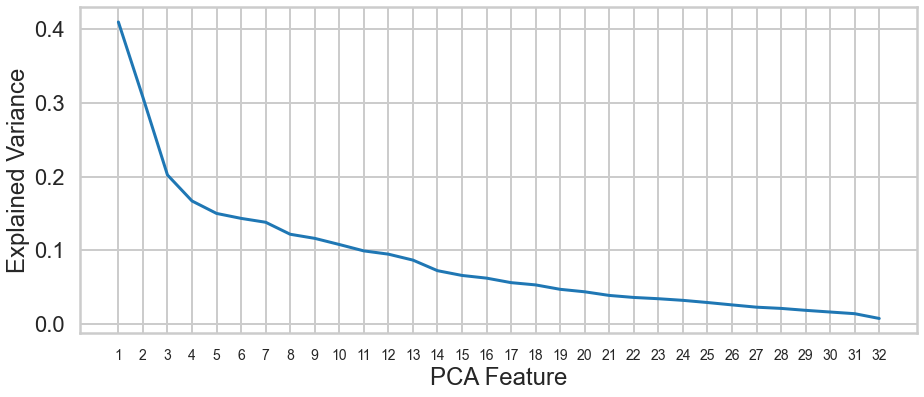

In [26]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
figpca = plt.figure(figsize=[15,6])

features = range(1,pca.n_components_+1)
plt.plot(features, pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained Variance')
plt.xticks(features, fontsize = 14)
plt.show()





The above plot of PCA features and explained variance has a marked slowdown at **n=3** and even further slowdown at n=4. 
We will take the lower of the two values, so n=3. This means that 3 PCA features can explain most of the variance amongst the observations.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

The consumers clusters generated by the KMeans clustering algorithm were evaluated using different techniques such as sum-of-squares and silhouette scores. Based on the evaluation criteria, both indicated an optimal no. of clusters as **3**.

The 3 clusters were then analysed using raw data for differences in parameters such as wine variety and origin. It was found that clusters had very different preferences for **wine variety** and some differences on **origin**.

The Principal Component Analysis revealed that 3 components explained a significant amount of the variation amongst the samples (customers).

So overall, the customers can be clustered into 3 clusters and 3 features explain most of the variance among the clusters.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [ ]:
# Your turn

In [69]:
from sklearn.cluster import AffinityPropagation

# Compute Affinity Propagation

avg_silhouette_score = []

preference = [-40, -30, -25, -20, -15, -10]

for pref in preference:
    af = AffinityPropagation(preference=pref, random_state=123).fit(x_cols)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    
    labels = af.labels_
    
    avg_silhouette_score.append(silhouette_score(x_cols, labels))
 
    print(f"Preference parameter = {pref} \nNo_of_clusters = {n_clusters_} \nAverage silhouette_score = {avg_silhouette_score[-1]:4.2}\n ")
    

Preference parameter = -40 
No_of_clusters = 2 
Average silhouette_score = 0.08
 
Preference parameter = -30 
No_of_clusters = 3 
Average silhouette_score = 0.11
 
Preference parameter = -25 
No_of_clusters = 3 
Average silhouette_score = 0.085
 
Preference parameter = -20 
No_of_clusters = 4 
Average silhouette_score = 0.087
 
Preference parameter = -15 
No_of_clusters = 5 
Average silhouette_score = 0.092
 
Preference parameter = -10 
No_of_clusters = 10 
Average silhouette_score = 0.094
 


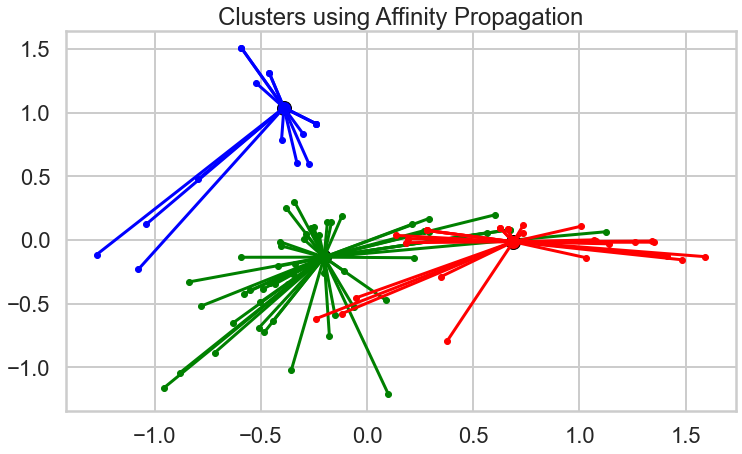

In [96]:
# From the above iterations, n=3 returns the best silhouette score of 0.11 for preference = -30
# Let's plot the clusters by reducing data points to two dimensions using PCA

import matplotlib.pyplot as plt
from itertools import cycle

af = AffinityPropagation(preference=-30, random_state=123).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)


model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

fig, ax = plt.subplots(1,1, figsize=(12,7))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = df_transformed.iloc[cluster_centers_indices[k], 2:]
    ax.plot(df_transformed[class_members]['x'], df_transformed[class_members]['y'], col + ".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for i, row in df_transformed[class_members].iterrows():
        ax.plot([cluster_center[0], row['x']], [cluster_center[1], row['y']], col)

ax.set_title("Clusters using Affinity Propagation" )
plt.show()


Spectral Clustering Metrics
For no_of_clusters = 2, avg. silhouette score = 0.07631909829627558
For no_of_clusters = 3, avg. silhouette score = 0.10611539040197304
For no_of_clusters = 4, avg. silhouette score = 0.11581750804633346
For no_of_clusters = 5, avg. silhouette score = 0.09915711813463922
For no_of_clusters = 6, avg. silhouette score = 0.09847779745663406
For no_of_clusters = 7, avg. silhouette score = 0.07994664628899811
For no_of_clusters = 8, avg. silhouette score = 0.07351336799388206
For no_of_clusters = 9, avg. silhouette score = 0.09287801148143807
For no_of_clusters = 10, avg. silhouette score = 0.09169821201411053


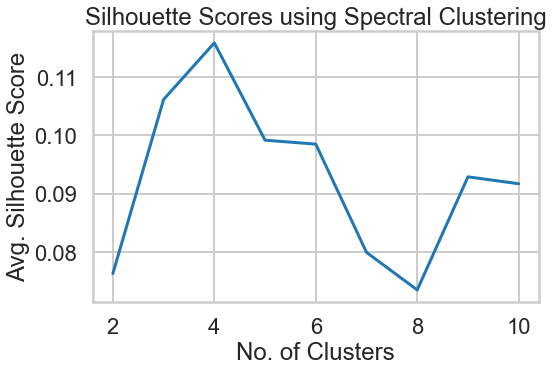

In [99]:
from sklearn.cluster import SpectralClustering

avg_silhouette_score = []

K_vals = list(range(2,11))
print('Spectral Clustering Metrics')

for K in K_vals:
    sc = SpectralClustering(n_clusters = K, random_state=123)
    labels = sc.fit_predict(x_cols)
    #centroids = model.cluster_centers_
    #ss_error.append(np.sum((x_cols - centroids[labels])**2))
    avg_silhouette_score.append(silhouette_score(x_cols, labels))
    
    print(f'For no_of_clusters = {K}, avg. silhouette score = {avg_silhouette_score[-1]}')

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(K_vals, avg_silhouette_score)
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('Avg. Silhouette Score')
ax.set_title('Silhouette Scores using Spectral Clustering')
plt.show()




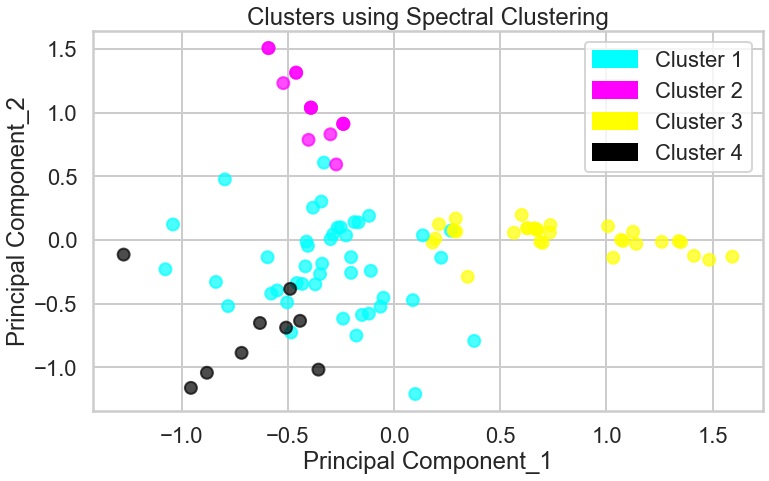

In [98]:
# Spectral Clustering gives the best Silhouette score for n=4 clusters. Let's plot the clusters

sc = SpectralClustering(n_clusters = 4, random_state=123)
labels = sc.fit_predict(x_cols)
    
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))

colors = {0:'cyan', 1:'magenta', 2:'yellow', 3:'black'}


scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

cyan_patch = mpatches.Patch(color='cyan', label='Cluster 1')
magenta_patch = mpatches.Patch(color='magenta', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')
black_patch = mpatches.Patch(color='black', label='Cluster 4')

ax.legend(handles=[cyan_patch, magenta_patch, yellow_patch, black_patch])
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title('Clusters using Spectral Clustering')
plt.show()

Agglomerative Clustering Metrics
For no_of_clusters = 2, avg. silhouette score = 0.08258017823184984
For no_of_clusters = 3, avg. silhouette score = 0.11625878863607858
For no_of_clusters = 4, avg. silhouette score = 0.128937578158815
For no_of_clusters = 5, avg. silhouette score = 0.14089739970831974
For no_of_clusters = 6, avg. silhouette score = 0.1471521720461323
For no_of_clusters = 7, avg. silhouette score = 0.15275152751051155
For no_of_clusters = 8, avg. silhouette score = 0.15578053718604024
For no_of_clusters = 9, avg. silhouette score = 0.12075124131971901
For no_of_clusters = 10, avg. silhouette score = 0.09754750747147792


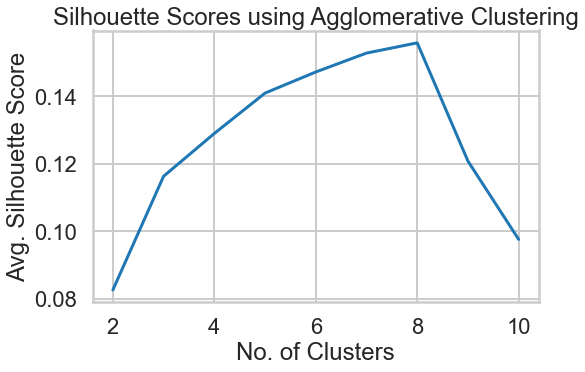

In [102]:
from sklearn.cluster import AgglomerativeClustering

avg_silhouette_score = []

K_vals = list(range(2,11))

print('Agglomerative Clustering Metrics')

for K in K_vals:
    ac = AgglomerativeClustering(n_clusters = K, linkage = 'ward')
    labels = ac.fit_predict(x_cols)
    
    avg_silhouette_score.append(silhouette_score(x_cols, labels))
    
    print(f'For no_of_clusters = {K}, avg. silhouette score = {avg_silhouette_score[-1]}')

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(K_vals, avg_silhouette_score)
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('Avg. Silhouette Score')
ax.set_title('Silhouette Scores using Agglomerative Clustering')
plt.show()


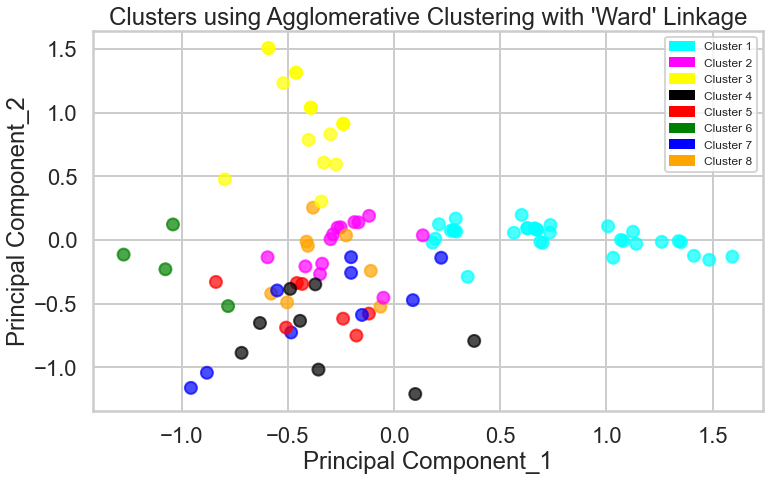

In [140]:
# Agglomerative Clustering gives the best Silhouette score for n=8 clusters. Let's plot the clusters

from matplotlib.colors import ListedColormap

ac = AgglomerativeClustering(n_clusters = 8, linkage='ward')
labels = ac.fit_predict(x_cols)
    
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))

colors = {0:'cyan', 1:'magenta', 2:'yellow', 3:'black', 4:'red', 5:'green', 6:'blue', 7:'orange'}

scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

cyan_patch = mpatches.Patch(color='cyan', label='Cluster 1')
magenta_patch = mpatches.Patch(color='magenta', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')
black_patch = mpatches.Patch(color='black', label='Cluster 4')
red_patch = mpatches.Patch(color='red', label = 'Cluster 5')
green_patch = mpatches.Patch(color='green', label = 'Cluster 6')
blue_patch = mpatches.Patch(color='blue', label = 'Cluster 7')
orange_patch = mpatches.Patch(color='orange', label = 'Cluster 8')


ax.legend(handles=[cyan_patch, magenta_patch, yellow_patch, black_patch, red_patch, green_patch, blue_patch, orange_patch], fontsize=12)
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title("Clusters using Agglomerative Clustering with 'Ward' Linkage")
plt.show()

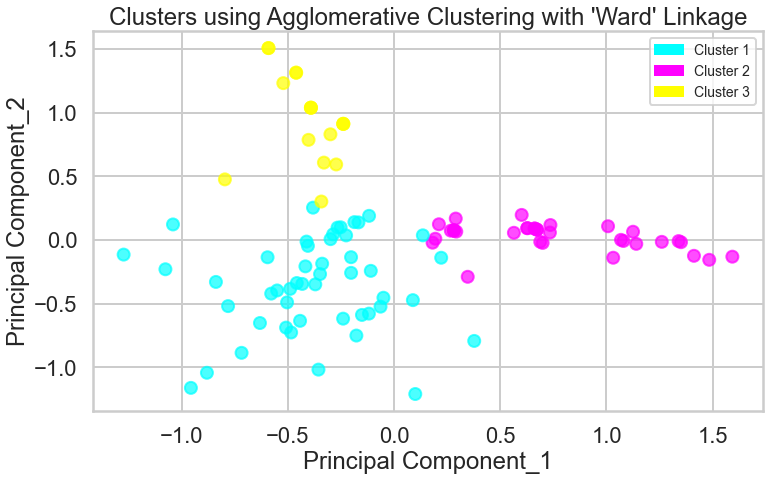

In [141]:
#Many of the above clusters have overlapping datapoints. Let's try using n=3, where there is a bend in the silhouette chart.

from matplotlib.colors import ListedColormap

ac = AgglomerativeClustering(n_clusters = 3, linkage='ward')
labels = ac.fit_predict(x_cols)
    
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))

colors = {0:'cyan', 1:'magenta', 2:'yellow'}

scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

cyan_patch = mpatches.Patch(color='cyan', label='Cluster 1')
magenta_patch = mpatches.Patch(color='magenta', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')

ax.legend(handles=[cyan_patch, magenta_patch, yellow_patch], fontsize=14)
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title("Clusters using Agglomerative Clustering with 'Ward' Linkage")
plt.show()


Agglomerative Clustering Metrics
For no_of_clusters = 2, avg. silhouette score = 0.2348896595208253
For no_of_clusters = 3, avg. silhouette score = 0.0564209072156317
For no_of_clusters = 4, avg. silhouette score = 0.04965592388360875
For no_of_clusters = 5, avg. silhouette score = 0.08118536531581164
For no_of_clusters = 6, avg. silhouette score = 0.09326599371031147
For no_of_clusters = 7, avg. silhouette score = 0.11408332240584
For no_of_clusters = 8, avg. silhouette score = 0.1113991600144103
For no_of_clusters = 9, avg. silhouette score = 0.11363460500092837
For no_of_clusters = 10, avg. silhouette score = 0.11955909579643043


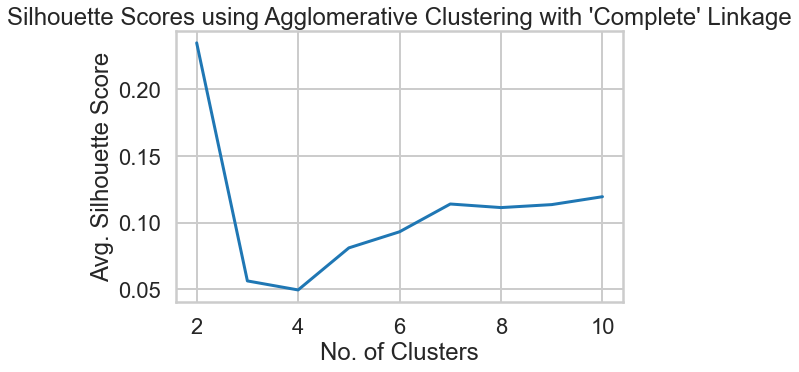

In [142]:
#We tried the 'ward' linkage method above. Let's check results for 'complete' linkage method.

from sklearn.cluster import AgglomerativeClustering

avg_silhouette_score = []

K_vals = list(range(2,11))

print('Agglomerative Clustering Metrics')

for K in K_vals:
    ac = AgglomerativeClustering(n_clusters = K, linkage = 'complete')
    labels = ac.fit_predict(x_cols)
    
    avg_silhouette_score.append(silhouette_score(x_cols, labels))
    
    print(f'For no_of_clusters = {K}, avg. silhouette score = {avg_silhouette_score[-1]}')

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(K_vals, avg_silhouette_score)
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('Avg. Silhouette Score')
ax.set_title("Silhouette Scores using Agglomerative Clustering with 'Complete' Linkage")
plt.show()

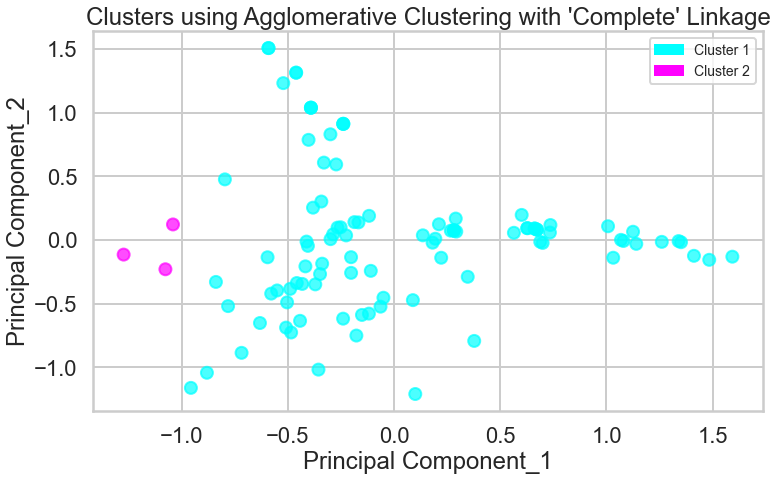

In [143]:
# This approach gives best scores at n=2. Let's plot the two clusters.

ac = AgglomerativeClustering(n_clusters = 2, linkage='complete')
labels = ac.fit_predict(x_cols)
    
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))

colors = {0:'cyan', 1:'magenta'}

scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

cyan_patch = mpatches.Patch(color='cyan', label='Cluster 1')
magenta_patch = mpatches.Patch(color='magenta', label='Cluster 2')

ax.legend(handles=[cyan_patch, magenta_patch], fontsize=14)
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title("Clusters using Agglomerative Clustering with 'Complete' Linkage")
plt.show()


So in Agglomerative clustering we see that the 'ward' linkage method gives better results.


In [127]:
# Now let's use DBSCAN for generating clusters. We initially specify eps = 0.2 and min_samples = 5

from sklearn.cluster import DBSCAN

eps = 0.2
min_samples = 5

dbs = DBSCAN(eps = eps, min_samples=min_samples)
labels = dbs.fit_predict(x_cols)
    
num_clusters = len(np.unique(labels[labels != -1]))
    
num_noise = np.sum(np.where(labels ==-1, 1, 0))
    
#avg_silhouette_score = silhouette_score(x_cols, labels)

print(f'For eps = {eps:3.2} and min_samples = {min_samples}, no. of clusters = {num_clusters} and no. of noisy samples = {num_noise}')



For eps = 0.2 and min_samples = 5, no. of clusters = 0 and no. of noisy samples = 100


In [136]:

# So we got all noise! Let's play around with eps and min_samples a bit

eps = [0.01,0.1,0.2,0.5,0.75, 1.0]
min_samples = [3,5,7,10]
print("DBSCAN Clustering Metrics")
    
for e in eps:
    for samples in min_samples:
        dbs = DBSCAN(eps = e, min_samples=samples)
        labels = dbs.fit_predict(x_cols)
    
        num_clusters = len(np.unique(labels[labels != -1]))
        num_noise = np.sum(np.where(labels == -1, 1, 0))

        print(f'For eps = {e:3.2} and min_samples = {samples}, no. of clusters = {num_clusters} and no. of noisy samples = {num_noise}')


DBSCAN Clustering Metrics
For eps = 0.01 and min_samples = 3, no. of clusters = 3 and no. of noisy samples = 91
For eps = 0.01 and min_samples = 5, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.01 and min_samples = 7, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.01 and min_samples = 10, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.1 and min_samples = 3, no. of clusters = 3 and no. of noisy samples = 91
For eps = 0.1 and min_samples = 5, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.1 and min_samples = 7, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.1 and min_samples = 10, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.2 and min_samples = 3, no. of clusters = 3 and no. of noisy samples = 91
For eps = 0.2 and min_samples = 5, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.2 and min_samples = 7, no. of clusters = 0 and no. of noisy samples = 100
For eps = 0.2 and min_sam

In [ ]:
# Notice that no. of noisy samples goes down only with eps = 1.0. And even in best scenario(eps = 1.0, min_samples = 3)
# there are still 51 samples categorized as noise. Let's plot the graph for this option.

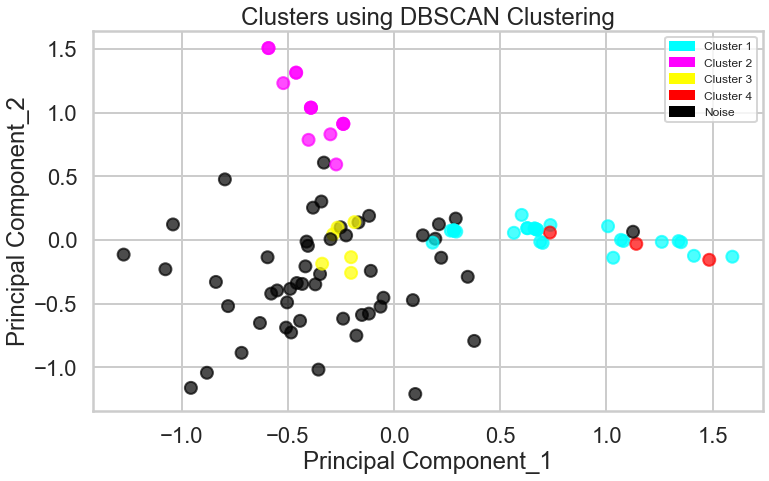

In [130]:

dbs = DBSCAN(eps = 1.0, min_samples=3)
labels = dbs.fit_predict(x_cols)
    
 
model = PCA(n_components=2)
model.fit(x_cols)
transformed = model.transform(x_cols)

df_transformed = pd.DataFrame({'customer_name': df_cust_offer_map['customer_name'], 'cluster': labels, \
                               'x': transformed[:,0], 'y': transformed[:,1]})

fig, ax = plt.subplots(1,1, figsize=(12,7))


colors = {-1: 'black', 0:'cyan', 1:'magenta', 2:'yellow', 3:'red'}

scatter = ax.scatter(df_transformed['x'], df_transformed['y'], c= df_transformed['cluster'].map(colors), alpha = 0.7)

cyan_patch = mpatches.Patch(color='cyan', label='Cluster 1')
magenta_patch = mpatches.Patch(color='magenta', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')
red_patch = mpatches.Patch(color='red', label = 'Cluster 4')
black_patch = mpatches.Patch(color='black', label='Noise')

ax.legend(handles=[cyan_patch, magenta_patch, yellow_patch, red_patch, black_patch], fontsize=12)
ax.set_xlabel('Principal Component_1')
ax.set_ylabel('Principal Component_2')
ax.set_title('Clusters using DBSCAN Clustering')
plt.show()


Based on all the other clustering methods applied to the dataset, the best results were generated by Agglomerative Clustering using the 'ward' linkage method. 

Given that our dataset is 'sparse' with only 100 observations across 32 features, Agglomerative Clustering works the best as it starts with the two closest samples and then merges others= samples into the cluster that they are closes to. As such it uses a 'flexible' distance metric of proximity and thus performs the best job in clustering the sparse dataset. Algorithms such as DBSCAN do not work here as they work on a density appraoch which doesn't seem to work as well with a 'sparse' daatset.

Overall, with this datset, K-Means approach works as the most practical as it allows easy comparison of different clustering options using metrics like sum_of_square or silhouette scores and then making a 'practical' trade-off betw
